In [1]:
pip install pydotplus

In [2]:
## TensorFlow
import tensorflow as tf

## Other libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (auc, precision_recall_curve, confusion_matrix,
                             roc_auc_score, roc_curve, classification_report,
                             precision_score, recall_score, f1_score, accuracy_score,
                             roc_curve, auc, ConfusionMatrixDisplay)
from sklearn.model_selection import (train_test_split, RandomizedSearchCV)
from scipy.stats import randint
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from IPython.display import (SVG, Image)
from sklearn.tree import export_graphviz
from sklearn.linear_model import LogisticRegression
import graphviz
from sklearn.ensemble import RandomForestClassifier

In [3]:
def unique_value_counts(array):
    array = np.array(array)  # Convert to numpy array if not already
    unique, counts = np.unique(array, return_counts=True)
    return dict(zip(unique, counts))

In [4]:
def calculate_metrics(y_true, y_pred, y_prob=None, metrics=['precision', 'recall', 'f1', 'accuracy', 'auc']):
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    TP = cm[1, 1]
    FP = cm[0, 1]
    TN = cm[0, 0]
    FN = cm[1, 0]

    results = {}

    # Calculate precision
    if 'precision' in metrics:
        results['precision'] = round( TP / (TP + FP), 4) if (TP + FP) > 0 else 0

    # Calculate recall
    if 'recall' in metrics:
        results['recall'] = round( TP / (TP + FN), 4) if (TP + FN) > 0 else 0

    # Calculate F1 score
    if 'f1' in metrics:
        results['f1'] = round( 2 * (TP / (2 * TP + FP + FN)), 4) if (2 * TP + FP + FN) > 0 else 0

    # Calculate accuracy
    if 'accuracy' in metrics:
        results['accuracy'] = round( (TP + TN) / (TP + TN + FP + FN), 4)

    # Calculate AUC
    if 'auc' in metrics and y_prob is not None:
        # Note: AUC requires probabilities, not class labels.
        results['auc'] = round( roc_auc_score(y_true, y_prob), 4)

    return results


# Data set-up

In [5]:
# Load the dataset
data = pd.read_excel('cleaned data.xlsx')

# Save as dataframe
data = pd.DataFrame(data)

In [6]:
# create X (features) and y (response)
X = data.drop(['Pno', 'Take-up ind'], axis = 1)
y = data['Take-up ind']

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the data
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# all my variables as seen as floats rather than strings or integers
X = X.astype(np.float32).values
y = y.astype(np.float32).values

In [7]:
# Get the test set (10%)
x_train_val, x_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=7)

# Now training (70%) and validation sets (20%)
x_train, x_val, y_train, y_val = train_test_split(
    x_train_val, y_train_val, test_size=0.2222, stratify=y_train_val, random_state=7)

# Apply SMOTE to the training data
smote = SMOTE(random_state=7)
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)

# Version 1 - NO SMOTE

In [10]:
# build
model = RandomForestClassifier(n_estimators=100, random_state=7, criterion='gini')

# fit and save
model.fit(x_train, y_train)

RandomForestClassifier(random_state=7)

In [11]:
# Predict
y_probs = model.predict(x_train)
y_train_pred = (y_probs > 0.5).astype(int) # Apply threshold
print(unique_value_counts(y_train_pred))
# Metrics
metrics = calculate_metrics(y_true=y_train, y_pred=y_train_pred, y_prob=y_probs,
                            metrics=['precision', 'recall', 'f1', 'accuracy', 'auc'])
print(metrics)


{0: 692, 1: 73}
{'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'accuracy': 1.0, 'auc': 1.0}


In [12]:
# Predict
y_probs = model.predict(x_val)
y_val_pred = (y_probs > 0.5).astype(int) # Apply threshold
print(unique_value_counts(y_val_pred))

# Metrics
metrics = calculate_metrics(y_true=y_val, y_pred=y_val_pred, y_prob=y_probs,
                            metrics=['precision', 'recall', 'f1', 'accuracy', 'auc'])
print(metrics)

{0: 215, 1: 4}
{'precision': 0.5, 'recall': 0.0952, 'f1': 0.16, 'accuracy': 0.9041, 'auc': 0.5426}


# Version 2 - SMOTE

In [13]:
# build
model = RandomForestClassifier(n_estimators=100, random_state=7, criterion='gini')

# fit and save
model.fit(x_train_smote, y_train_smote)

RandomForestClassifier(random_state=7)

In [16]:
# Predict
y_probs = model.predict(x_train_smote)
y_train_pred = (y_probs > 0.5).astype(int) # Apply threshold
print(unique_value_counts(y_train_pred))
# Metrics
metrics = calculate_metrics(y_true=y_train_smote, y_pred=y_train_pred, y_prob=y_probs,
                            metrics=['precision', 'recall', 'f1', 'accuracy', 'auc'])
print(metrics)

{0: 692, 1: 692}
{'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'accuracy': 1.0, 'auc': 1.0}


In [17]:
# Predict
y_probs = model.predict(x_val)
y_val_pred = (y_probs > 0.5).astype(int) # Apply threshold
print(unique_value_counts(y_val_pred))

# Metrics
metrics = calculate_metrics(y_true=y_val, y_pred=y_val_pred, y_prob=y_probs,
                            metrics=['precision', 'recall', 'f1', 'accuracy', 'auc'])
print(metrics)

{0: 199, 1: 20}
{'precision': 0.25, 'recall': 0.2381, 'f1': 0.2439, 'accuracy': 0.8584, 'auc': 0.5812}


# Version 3 - SMOTE, entropy

In [18]:
# build
model = RandomForestClassifier(n_estimators=100, random_state=7, criterion='entropy')

# fit and save
model.fit(x_train_smote, y_train_smote)

RandomForestClassifier(criterion='entropy', random_state=7)

In [19]:
# Predict
y_probs = model.predict(x_train_smote)
y_train_pred = (y_probs > 0.5).astype(int) # Apply threshold
print(unique_value_counts(y_train_pred))
# Metrics
metrics = calculate_metrics(y_true=y_train_smote, y_pred=y_train_pred, y_prob=y_probs,
                            metrics=['precision', 'recall', 'f1', 'accuracy', 'auc'])
print(metrics)

{0: 692, 1: 692}
{'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'accuracy': 1.0, 'auc': 1.0}


In [20]:
# Predict
y_probs = model.predict(x_val)
y_val_pred = (y_probs > 0.5).astype(int) # Apply threshold
print(unique_value_counts(y_val_pred))

# Metrics
metrics = calculate_metrics(y_true=y_val, y_pred=y_val_pred, y_prob=y_probs,
                            metrics=['precision', 'recall', 'f1', 'accuracy', 'auc'])
print(metrics)

{0: 198, 1: 21}
{'precision': 0.2381, 'recall': 0.2381, 'f1': 0.2381, 'accuracy': 0.8539, 'auc': 0.5786}


# HYPERPARAMETER TUNING

In [ ]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20),
              'criterion':['gini', 'entropy', 'log_loss'],
              }

In [ ]:
# Create a random forest classifier
model = RandomForestClassifier(random_state=42)

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(model,
                                 param_distributions = param_dist,
                                 n_iter=5,
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(x_train_smote, y_train_smote)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=5,
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000108C8C49FD0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000108C673D5D0>})

In [ ]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'criterion': 'gini', 'max_depth': 11, 'n_estimators': 260}


# Rebuild the best tuned and chosen model

In [21]:
# build
model = RandomForestClassifier(n_estimators=260, random_state=7, criterion='gini', max_depth=11)

# fit and save
model.fit(x_train_smote, y_train_smote)

RandomForestClassifier(max_depth=11, n_estimators=260, random_state=7)

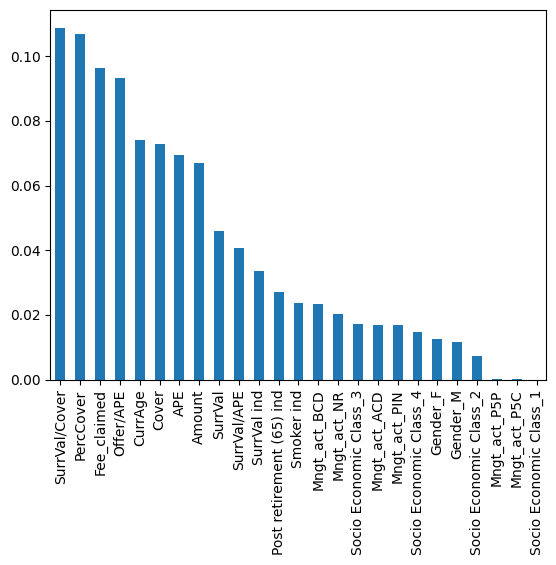

In [ ]:
x_train_cols = ['Amount', 'Cover', 'SurrVal', 'Offer/APE', 'PercCover', 'CurrAge',
       'Fee_claimed', 'Smoker ind', 'APE', 'SurrVal/APE', 'SurrVal/Cover',
       'SurrVal ind', 'Post retirement (65) ind', 'Gender_F', 'Gender_M',
       'Mngt_act_ACD', 'Mngt_act_BCD', 'Mngt_act_NR', 'Mngt_act_P5C',
       'Mngt_act_P5P', 'Mngt_act_PIN', 'Socio Economic Class_1',
       'Socio Economic Class_2', 'Socio Economic Class_3',
       'Socio Economic Class_4']

# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(model.feature_importances_, index=x_train_cols).sort_values(ascending=False)

# Plot bar chart
feature_importances.plot.bar();

In [22]:
# Predict
y_probs = model.predict(x_train_smote)
y_train_pred = (y_probs > 0.5).astype(int) # Apply threshold
print(unique_value_counts(y_train_pred))
# Metrics
metrics = calculate_metrics(y_true=y_train_smote, y_pred=y_train_pred, y_prob=y_probs,
                            metrics=['precision', 'recall', 'f1', 'accuracy', 'auc'])
print(metrics)

{0: 651, 1: 733}
{'precision': 0.9441, 'recall': 1.0, 'f1': 0.9712, 'accuracy': 0.9704, 'auc': 0.9704}


In [23]:
# Predict
y_probs = model.predict(x_val)
y_val_pred = (y_probs > 0.5).astype(int) # Apply threshold
print(unique_value_counts(y_val_pred))

# Metrics
metrics = calculate_metrics(y_true=y_val, y_pred=y_val_pred, y_prob=y_probs,
                            metrics=['precision', 'recall', 'f1', 'accuracy', 'auc'])
print(metrics)

{0: 189, 1: 30}
{'precision': 0.2667, 'recall': 0.381, 'f1': 0.3137, 'accuracy': 0.8402, 'auc': 0.6349}


In [ ]:
# Predict
y_probs = model.predict(x_test)
y_test_pred = (y_probs > 0.5).astype(int) # Apply threshold
print(unique_value_counts(y_test_pred))

# Metrics
metrics = calculate_metrics(y_true=y_test, y_pred=y_test_pred, y_prob=y_probs,
                            metrics=['precision', 'recall', 'f1', 'accuracy', 'auc'])
print(metrics)

{0: 88, 1: 22}
{'precision': 0.2727, 'recall': 0.6, 'f1': 0.375, 'accuracy': 0.8182, 'auc': 0.72}


In [ ]:
cm_df = pd.DataFrame(confusion_matrix(y_test_pred, y_test),
                     index=['Actual 0', 'Actual 1'],
                     columns=['Predicted 0', 'Predicted 1'])
cm_df

,Predicted 0,Predicted 1
Actual 0,86,4
Actual 1,14,6


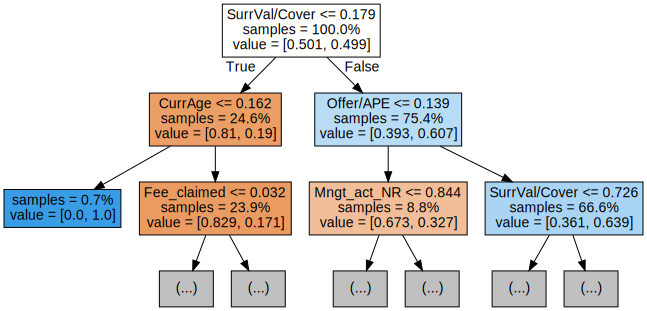

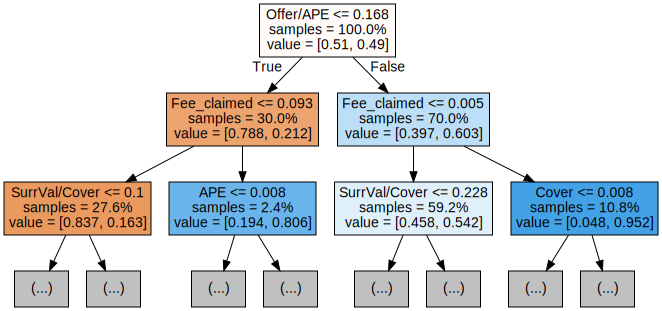

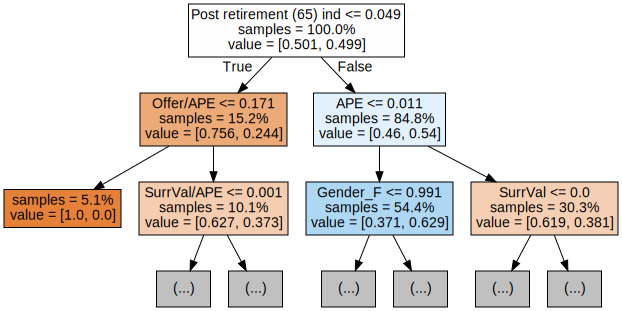

In [ ]:
# Export the first three decision trees from the forest

x_train_cols = ['Amount', 'Cover', 'SurrVal', 'Offer/APE', 'PercCover', 'CurrAge',
       'Fee_claimed', 'Smoker ind', 'APE', 'SurrVal/APE', 'SurrVal/Cover',
       'SurrVal ind', 'Post retirement (65) ind', 'Gender_F', 'Gender_M',
       'Mngt_act_ACD', 'Mngt_act_BCD', 'Mngt_act_NR', 'Mngt_act_P5C',
       'Mngt_act_P5P', 'Mngt_act_PIN', 'Socio Economic Class_1',
       'Socio Economic Class_2', 'Socio Economic Class_3',
       'Socio Economic Class_4']

for i in range(3):
    tree = model.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=x_train_cols,
                               filled=True,
                               max_depth=2,
                               impurity=False,
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

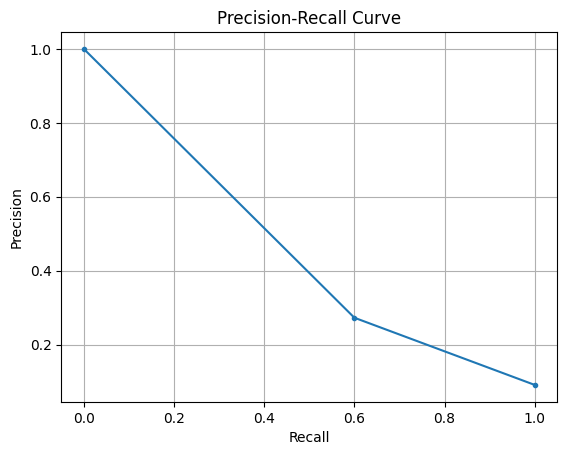

In [ ]:
# Compute precision and recall values
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Plot the Precision-Recall curve
plt.figure()
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

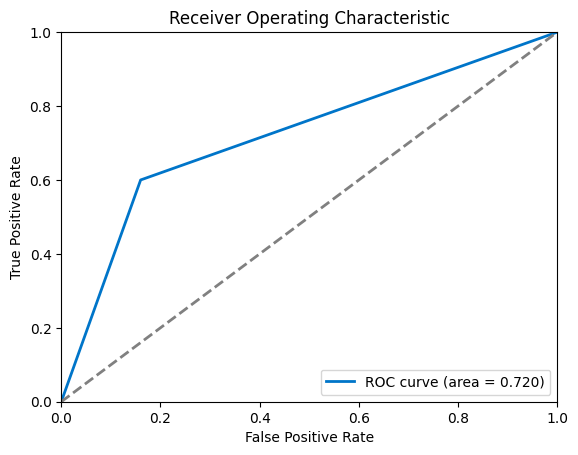

In [ ]:
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='#0075C9', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()